### Trust Score

Goal: Assess how trustworthy the listing and seller seem.

* Price deviation from neighborhood average
* Formal writing style (based on cluster)

### Transparency 

Goal: Reflect how clearly and completely the listing conveys information.

* Description length (not too short or verbose)
* Presence of descriptive/technical keywords (e.g., "renovated", "well-lit")

### Appeal Score

Goal: Measure how emotionally attractive or engaging the ad is.

* Emotional/positive marketing words (e.g., "amazing offer")
* Structure and readability (sentence count, formatting)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.optimize import minimize
import itertools
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping

2025-06-09 21:53:37.552720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749506017.794415      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749506017.868533      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data preparation and feature extraction

In [2]:
# -------------------- Load datasets --------------------
main_df = pd.read_csv('/kaggle/input/real-estate-data-after-clustering/real_estate_main_with_clusters.csv')
structured_df = pd.read_csv('/kaggle/input/real-estate-data-after-clustering/real_estate_structured_with_writing_clusters.csv')

# -------------------- Stylistic Features --------------------
def extract_stylistic_features(df):
    formal_words = ["می‌باشد", "محترم", "عالیجناب", "بااحترام", "خواهشمند است"] #LLM
    emotional_phrases = ["فرصت استثنایی", "خوش‌قیمت", "فول امکانات", "بینظیر", "لاکچری", "دنج","بی نظیر","نقلی", "خوش قیمت"] #LLM

    df = df.copy()
    df["avg_word_len"] = df["description_clean"].apply(
        lambda x: np.mean([len(w) for w in x.split()]) if isinstance(x, str) else 0
    )
    df["punct_density"] = df["description_clean"].str.count(r"[^\w\s]").div(
        df["description_clean"].str.len().replace(0, np.nan)
    ).fillna(0)
    df["formal_word_count"] = df["description_clean"].apply(
        lambda x: sum(w in x for w in formal_words) if isinstance(x, str) else 0
    )
    df["emotional_word_count"] = df["description_clean"].apply(
        lambda x: sum(w in x for w in emotional_phrases) if isinstance(x, str) else 0
    )
    df["num_lines"] = df["description_clean"].str.count("\n") + 1
    df["num_digits"] = df["description_clean"].str.count(r"\d")

    return df[[
        "avg_word_len", "punct_density", "formal_word_count", 
        "emotional_word_count", "num_lines", "num_digits"
    ]].fillna(0)

stylistic_features = extract_stylistic_features(main_df)

# -------------------- TF-IDF Keyword Richness --------------------
tfidf_vectorizer = TfidfVectorizer(max_features=300)
tfidf_matrix = tfidf_vectorizer.fit_transform(main_df["description_clean"].fillna(""))
keyword_richness = tfidf_matrix.mean(axis=1).A1
keyword_richness = MinMaxScaler().fit_transform(keyword_richness.reshape(-1, 1)).flatten()

/tmp/ipykernel_19/3006994754.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv('/kaggle/input/real-estate-data-after-clustering/real_estate_main_with_clusters.csv')


# Final preparation of features and normalization

In [3]:
# -------------------- Feature groups --------------------
features_for_trust = ["price_per_sqm"]
features_for_transparency = ["description_length", "description_word_count", "total_amenities"]
features_for_appeal = ["rooms_count", "building_size", "has_multiple_pricing_options"]

# Add the feature rooms_count from main_df to structured_df for use in appeal
structured_df["rooms_count"] = main_df["rooms_count"]

# Combine all features
combined_features_df = pd.concat([
    structured_df[features_for_trust + features_for_transparency + features_for_appeal],
    stylistic_features,
    main_df[["has_phone_number"]]
], axis=1).fillna(0)

# -------------------- Normalization --------------------
scaler = MinMaxScaler()
normalized_features = pd.DataFrame(
    scaler.fit_transform(combined_features_df),
    columns=combined_features_df.columns
)

# optimizing the weights of the sub-indicators (Trust, Transparency, Appeal) WITH Grid Search AND optimization-based


In [4]:
def optimize_weights(X, score_fn='variance'):
    n = X.shape[1]

    # Objective function to minimize
    def objective(weights):
        weighted_sum = np.dot(X, weights)

        if score_fn == 'variance':
            return np.var(weighted_sum)
        elif score_fn == 'flatness':
            return np.mean((weighted_sum - np.mean(weighted_sum))**2)
        elif score_fn == 'range':
            return np.max(weighted_sum) - np.min(weighted_sum)
        else:
            raise ValueError("Invalid score_fn")

    # Constraint: sum of weights = 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Weight bounds: between 0 and 1
    bounds = [(0, 1)] * n

    # Initial values: equal weights
    initial_weights = np.ones(n) / n

    result = minimize(
        objective,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if result.success:
        return result.x
    else:
        raise RuntimeError("Optimization failed: " + result.message)


In [5]:
def best_weighted_sum(X, score_fn='variance', step=0.1):
    """
    Grid search for the best weighted combination of features
    - score_fn: 'variance' or 'flatness' or 'range'
    """
    n = X.shape[1]
    weights_pool = np.arange(step, 1.01, step)
    weight_combinations = list(itertools.product(weights_pool, repeat=n))
    weight_combinations = [w for w in weight_combinations if np.isclose(sum(w), 1, atol=1e-3)]

    best_weights = None
    best_score = float('inf')

    for weights in weight_combinations:
        weighted_sum = np.dot(X, weights)

        if score_fn == 'variance':
            score = np.var(weighted_sum)

        elif score_fn == 'flatness':
            score = np.mean((weighted_sum - np.mean(weighted_sum))**2)

        elif score_fn == 'range':
            score = np.max(weighted_sum) - np.min(weighted_sum)

        else:
            raise ValueError("Invalid score_fn")

        if score < best_score:
            best_score = score
            best_weights = weights

    return best_weights

In [6]:
# Redefining feature groups for clarity
trust_features = ["price_per_sqm", "formal_word_count", "has_phone_number"]
transparency_features = ["description_length", "description_word_count", "total_amenities", "num_digits"]
appeal_features = ["rooms_count", "building_size", "emotional_word_count", "has_multiple_pricing_options", "punct_density"]

# Extracting data for each indicator from normalized_features
X_trust = normalized_features[trust_features]
X_transparency = normalized_features[transparency_features]
X_appeal = normalized_features[appeal_features]

In [7]:
# Running Grid Search
trust_weights = best_weighted_sum(X_trust, score_fn='variance', step=0.1)
transparency_weights = best_weighted_sum(X_transparency, score_fn='flatness')
appeal_weights = best_weighted_sum(X_appeal, score_fn='range')

# optimization-based
# trust_weights = optimize_weights(X_trust, score_fn='variance')
# transparency_weights = optimize_weights(X_transparency, score_fn='flatness')
# appeal_weights = optimize_weights(X_appeal, score_fn='range')

# Creating score for each indicator using optimal weights
normalized_features["trust_score"] = np.dot(X_trust, trust_weights)
normalized_features["transparency_score"] = np.dot(X_transparency, transparency_weights)
normalized_features["appeal_score"] = np.dot(X_appeal, appeal_weights)

In [8]:
main_df["trust_score"] = normalized_features["trust_score"]
main_df["transparency_score"] = normalized_features["transparency_score"]
main_df["appeal_score"] = normalized_features["appeal_score"]

# Generating the final score using Autoencoder (combining trust, transparency, appeal)

In [9]:
sub_scores = main_df[["trust_score", "transparency_score", "appeal_score"]]

# Standardize for better neural network learning
scaler_sub = StandardScaler()
sub_scaled = scaler_sub.fit_transform(sub_scores)

In [10]:
input_layer = Input(shape=(3,))
x = Dense(8, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(6, activation='relu')(x)
x = BatchNormalization()(x)

encoded = Dense(2, activation='relu', name='encoded_layer')(x)

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(8, activation='relu')(x)
x = BatchNormalization()(x)

decoded = Dense(3, activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.003), loss='mse')

I0000 00:00:1749506107.532431      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749506107.533160      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/200


I0000 00:00:1749506113.548286      63 service.cc:148] XLA service 0x79ffb4007ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749506113.548993      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749506113.549014      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749506114.043185      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


   64/17871 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 2.0522

I0000 00:00:1749506116.579594      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17871/17871 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - loss: 0.3484 - val_loss: 0.1396
Epoch 2/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.2309 - val_loss: 0.1317
Epoch 3/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.2250 - val_loss: 0.1565
Epoch 4/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.2253 - val_loss: 0.1311
Epoch 5/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 0.2252 - val_loss: 0.1237
Epoch 6/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 0.2220 - val_loss: 0.1230
Epoch 7/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 0.2230 - val_loss: 0.1350
Epoch 8/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.2212 - val_loss: 0.1522
Epoch 9/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.2200 - val_loss: 0.1475
Epoch 10/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.2209 - val_loss: 0.1267
Epoch 11/200
17871/17871 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.2204 - val_loss: 0.135

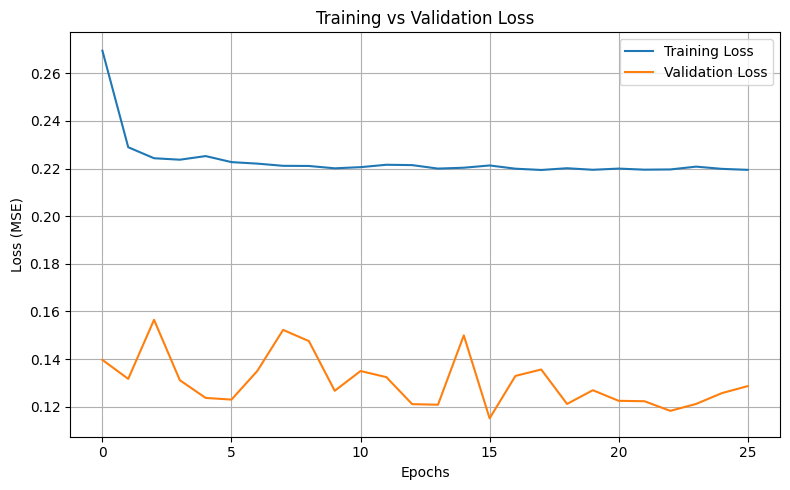

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

history = autoencoder.fit(
    sub_scaled, sub_scaled,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Plotting training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
encoder = Model(inputs=input_layer, outputs=encoded)
encoded_values = encoder.predict(sub_scaled)

22339/22339 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step


In [13]:
# Assumption: autoencoder is trained and sub_scaled (standardized trust/transparency/appeal features) is available

# ------------------ Step 1: Extract encoding vectors from Autoencoder ------------------
encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("encoded_layer").output
)

encoded_values = encoder.predict(sub_scaled)  # Output shape: (n_samples, 2)

# ------------------ Step 2: Apply PCA to construct the quality_score ------------------
pca = PCA(n_components=1)
quality_score_raw = pca.fit_transform(encoded_values)  # Output shape: (n_samples, 1)

# Normalize final score to the range 0–1
quality_score = MinMaxScaler().fit_transform(quality_score_raw).flatten()

# Add to final dataframe
main_df["quality_score"] = quality_score

# ------------------ Step 3: Extract weights of each sub-indicator in the final combination ------------------
# Note: The 3 input features (trust, transparency, appeal) led to encoded_values
# So we can compute PCA weights on those 3 using a separate fit:

pca_interpret = PCA(n_components=1)
pca_interpret.fit(sub_scaled)  # On trust/transparency/appeal

final_weights = dict(zip(["trust_score", "transparency_score", "appeal_score"], pca_interpret.components_[0]))

# ------------------ Display outputs ------------------
print("✅ Final quality score added to main_df (quality_score)")
print("✅ Component weights in final quality combination:")
for k, v in final_weights.items():
    print(f"  - {k}: {v:.3f}")

22339/22339 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
✅ Final quality score added to main_df (quality_score)
✅ Component weights in final quality combination:
  - trust_score: 0.506
  - transparency_score: 0.772
  - appeal_score: 0.384


# Print the final weights of each index in the final quality (quality_score)

In [14]:
# Assuming the column quality_score exists in main_df
bins = np.arange(0, 1.01, 0.1)  # Ranges: 0.0 - 0.1 - ... - 1.0
labels = [f"{round(b,1)}–{round(b+0.1,1)}" for b in bins[:-1]]

main_df["quality_bucket"] = pd.cut(main_df["quality_score"], bins=bins, labels=labels, include_lowest=True)

score_distribution = main_df["quality_bucket"].value_counts().sort_index()

print(score_distribution)

quality_bucket
0.0–0.1      4545
0.1–0.2     31216
0.2–0.3     85060
0.3–0.4    122719
0.4–0.5    129946
0.5–0.6    159357
0.6–0.7    106983
0.7–0.8     44317
0.8–0.9     16462
0.9–1.0     14222
Name: count, dtype: int64


# Final storage

In [15]:
# Save only the scores
main_df[[
    "quality_score", "trust_score", "transparency_score", "appeal_score"
]].to_csv("listing_quality_scores_final.csv", index=False)

# Save all information for further analysis in the future
main_df.to_csv("real_estate_with_all_scores.csv", index=False)

# Visualization of scores.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

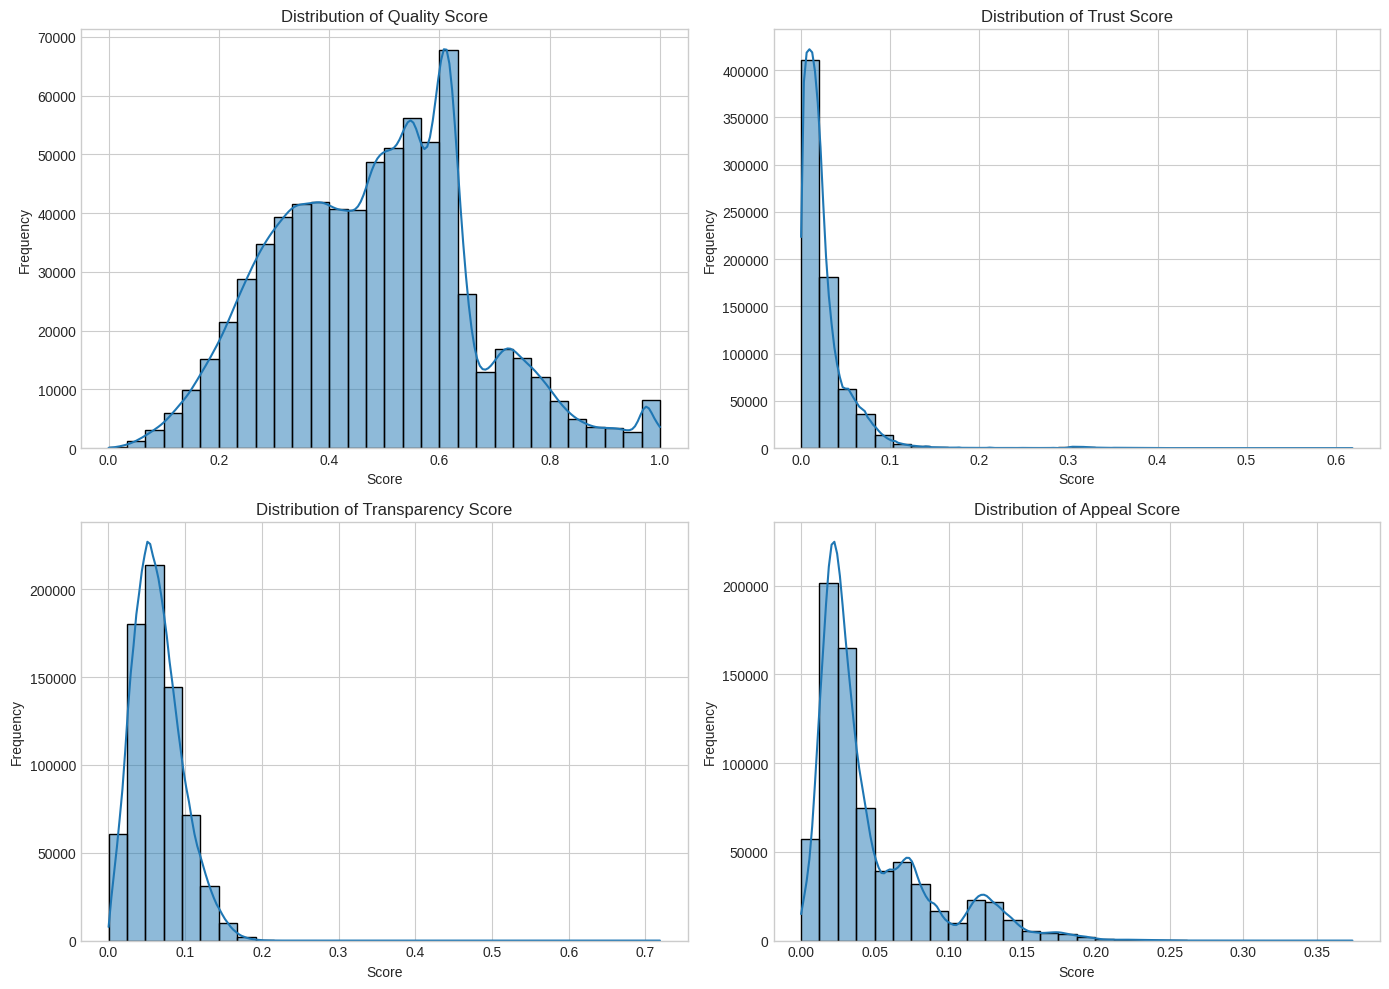

In [16]:
# Appearance settings
plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

score_columns = ["quality_score", "trust_score", "transparency_score", "appeal_score"]

for i, col in enumerate(score_columns):
    sns.histplot(main_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col.replace('_', ' ').title()}")
    axes[i].set_xlabel("Score")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()